### Introduction to computational sciences
### Lab Assignment 2
### Marleen Rijksen (10465030)

In [2]:
# imports
%pylab inline
pylab.rcParams['figure.figsize'] = [10, 8]
import numpy as np
from itertools import accumulate
import copy
from scipy.integrate import odeint

# for animation
from matplotlib import animation, rc
from IPython.display import HTML
rc('animation',html='html5')

Populating the interactive namespace from numpy and matplotlib


/home/marleen/anaconda3/lib/python3.6/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['beta', 'gamma']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


### Problem 1: Gillespies algorithm for SIR without demography

In [139]:
# function to calculate time evolution of stochastic SIR without demography
def Gill_SIR(beta, gamma, X, Y, Z, steps):
    
    # size of population
    N = X + Y + Z

    # lists to store variables
    X_list = [X]
    Y_list = [Y]
    Z_list = [Z]
    t_list = [0]

    for i in range(steps):

        # determine new rates each step 
        # rates[0] = transmission, rates[1] = recovery
        rates = [beta * X * Y / N, gamma * Y]
        Rtot = sum(rates)

        # time until next event occurs
        dt = (-1 / float(Rtot)) * np.log(np.random.random())
        t_list.append(t_list[i] + dt)

        # P = rand2 x Rtot
        P = np.random.random() * Rtot

        # event p occurs if P is between certain values
        if P < rates[0]:

            # transmission if there are susceptibles ?not sure about this one
            X -= 1
            Y += 1

        # recovery
        else:
            Z = Z + 1
            Y = Y - 1

        # add new variables to lists
        X_list.append(X)
        Y_list.append(Y)
        Z_list.append(Z)

        # the disease is extinct when the number of infecteds becomes 0
        if Y == 0:
            break   
    return X_list, Y_list, Z_list, t_list

#### Usage of Gillespies algorithm for SIR without demography

[[ 24973.50850846  -5934.86866527]
 [ -5934.86866527   7595.94062724]]


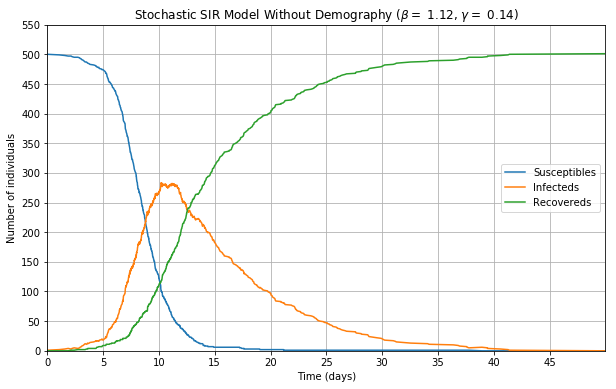

In [145]:
# constants and initial conditions
beta = 1.124
gamma = 1 / 7
X = 500
Y = 1
Z = 0
N = X + Y + Z
steps = 5000

# seed
np.random.seed(1337)

# calculate time evolution of model
X_list, Y_list, Z_list, t_list = Gill_SIR(beta, gamma, X, Y, Z, steps)

# covariance between X and Y
cov = np.cov(X_list, Y_list)
print(cov)

# plot results
plt.plot(t_list, X_list, label='Susceptibles')
plt.plot(t_list, Y_list, label='Infecteds')
plt.plot(t_list, Z_list, label='Recovereds')
plt.title('Stochastic SIR Model Without Demography ($\\beta =$ {:.2f}, $\\gamma = $ {:.2f})'.format(beta, gamma))
plt.ylabel('Number of individuals')
plt.xlabel('Time (days)')
plt.yticks(range(0, 600, 50))
plt.xticks(range(0, 50, 5))
plt.xlim(0, 50)
plt.ylim(0, 550)
plt.grid()
plt.legend(loc='center right')



plt.show()

#### Problem 1: Gillespies algorithm for SIR with demography

In [102]:
# function to calculate time evolution of stochastic SIR with demography
def Gill_SIR_dem(beta, gamma, mu, X, Y, Z, steps):
    
    # total population
    N = X + Y + Z
    
    # lists to store variables
    X_list = [X]
    Y_list = [Y]
    Z_list = [Z]
    t_list = [0]
    
    # variable to observe extinctions
    ext = False
    
    # extinction lists
    ext_timelist = []
    
    for i in range(steps):

        # rate of imports
        delta = 0.0625 * mu * (beta / gamma - 1) * np.sqrt(N) 

        # determine new rates each step 
        # rates[0] = births, [1] = transmission, [2] = recovery
        # deaths: [3] = X, [4] = Y, [5] = Z
        # rates[6] = imports
        rates = [mu * N, beta * X * Y / N, gamma * Y, mu * X, mu * Y, mu * Z, delta]
        Rtot = sum(rates)

        # cumulative list of rates
        rates_c = list(accumulate(rates))

        # time until next event occurs
        dt = (-1 / float(Rtot)) * np.log(np.random.random())
        t_list.append(t_list[i] + dt)

        # P = rand2 x Rtot
        P = np.random.random() * Rtot

        # births
        if P <= rates_c[0]:
            X += 1

        # transmission
        elif P <= rates_c[1]:
            Y += 1
            X -= 1

        # recovery
        elif P <= rates_c[2]:
            Z += 1
            Y -= 1

        # deaths
        elif P <= rates_c[3]:
            X -= 1
        elif P <= rates_c[4]:
            Y -= 1
        elif P <= rates_c[5]:
            Z -= 1 

        # imports
        elif P <= rates_c[6]:
            Y += 1

        # add new variables to lists
        X_list.append(X)
        Y_list.append(Y)
        Z_list.append(Z)
        
        # observe when extinctions happen
        if Y == 0 and ext == False:
            ext = True
            ext_timelist.append(t_list[i] + dt)
            
        elif Y > 0:
            ext = False
        
        # new population size
        N = X + Y + Z  
    return X_list, Y_list, Z_list, t_list, ext_timelist

#### Usage of Gillespie Algorithm for SIR with demography

We now use the Gillespie algorithm for certain parameters. The extinction hallmark is made visible here.

The covariance between the susceptible and infecteds class is -143.23.
Extinctions are after [8.8942127560661337, 15.408690341537687, 78.300184926842604, 86.268131058069883, 108.19134370208324, 138.2132732507261, 157.83101153871229, 162.20975325644432, 187.71839072661115] days.


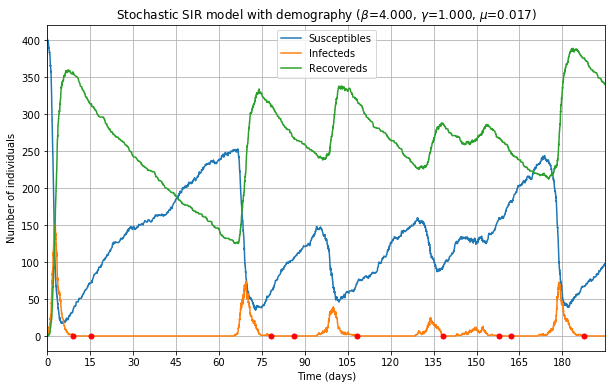

In [103]:
# constants and initial conditions
beta = 4
gamma = 1 
mu = 1 / 60
X = 400
Y = 1
Z = 0
steps = 5000

# seed 
np.random.seed(1337)

# use function
X_list, Y_list, Z_list, t_list, ext_timelist = Gill_SIR_dem(beta, gamma, mu, X, Y, Z, steps)

# covariance between X and Y
cov = np.cov(X_list, Y_list)
print("The covariance between the susceptible and infecteds class is {:.2f}.".format(cov[0][1]))

# print timestamps of extinctions
print("Extinctions are after {} days.".format(ext_timelist))

# plot results
plt.plot(t_list, X_list, label='Susceptibles')
plt.plot(t_list, Y_list, label='Infecteds')
plt.plot(t_list, Z_list, label='Recovereds')
plt.legend(loc='best')
plt.title('Stochastic SIR model with demography ($\\beta$={:.3f}, $\\gamma$={:.3f}, $\\mu$={:.3f})'.format(beta, gamma, mu))
plt.grid()
plt.xlim(0, 195)
plt.xlabel('Time (days)')
plt.ylabel('Number of individuals')
plt.xticks(range(0, 195, 15))

# plot extinctions
plt.plot(ext_timelist, [0 for x in range(len(ext_timelist))], 'o', markersize='5', color='r')
plt.show()


We can also demonstrate the variability in different simulations. When new simulations are run (with a different seed) the simulation will become different. For visibility we have chosen to visualize only the infecteds class. 


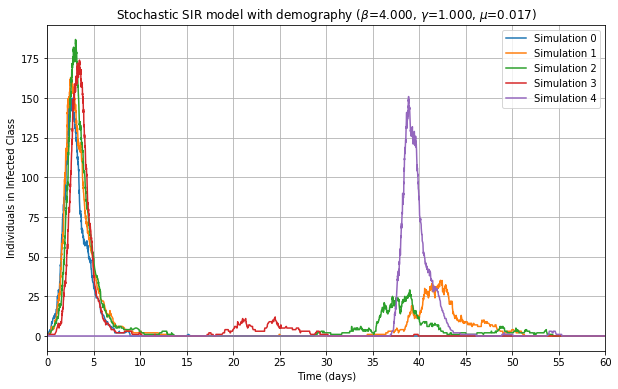

In [146]:
# constants and initial conditions
beta = 4
gamma = 1 
mu = 1 / 60
X = 400
Y = 1
Z = 0
steps = 8000

# seed 
np.random.seed(1337)

for i in range(5):

    # use function
    X_list, Y_list, Z_list, t_list, ext_timelist = Gill_SIR_dem(beta, gamma, mu, X, Y, Z, steps)

    # plot results
    plt.plot(t_list, Y_list, label='Simulation {}'.format(i))

# plot 
plt.legend(loc='best')
plt.title('Stochastic SIR model with demography ($\\beta$={:.3f}, $\\gamma$={:.3f}, $\\mu$={:.3f})'.format(beta, gamma, mu))
plt.xticks(range(0, 65, 5))
plt.grid()    
plt.xlim(0, 60)
plt.legend(loc='best')
plt.ylabel('Individuals in Infected Class')
plt.xlabel('Time (days)')
plt.show()


#### Stochastic resonance

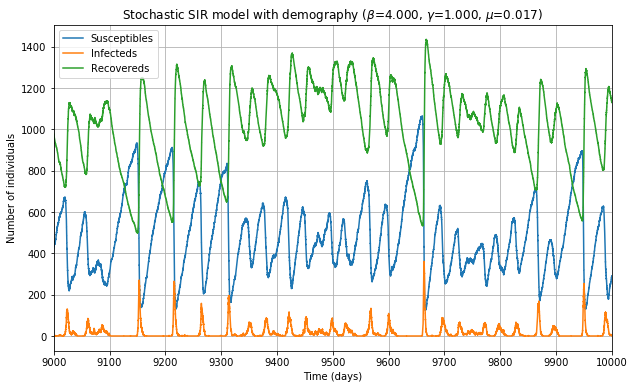

In [148]:
# constants and initial conditions
beta = 4
gamma = 1 
mu = 1 / 60
X = 400
Y = 1
Z = 0
steps = 500000

# seed 
np.random.seed(1337)

# use function
X_list, Y_list, Z_list, t_list, ext_timelist = Gill_SIR_dem(beta, gamma, mu, X, Y, Z, steps)

# plot results
plt.plot(t_list, X_list, label='Susceptibles')
plt.plot(t_list, Y_list, label='Infecteds')
plt.plot(t_list, Z_list, label='Recovereds')
plt.legend(loc='best')
plt.xticks(range(9000,11000, 100))
plt.title('Stochastic SIR model with demography ($\\beta$={:.3f}, $\\gamma$={:.3f}, $\\mu$={:.3f})'.format(beta, gamma, mu))
plt.grid()
plt.xlabel('Time (days)')
plt.ylabel('Number of individuals')
plt.xlim(9000, 10000)
plt.show()


#### Increased Transients

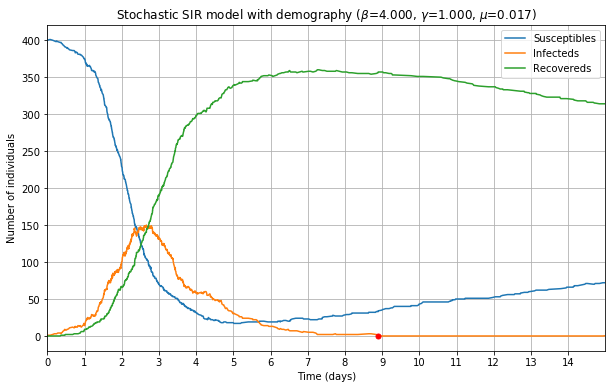

In [149]:
# constants and initial conditions
beta = 4
gamma = 1 
mu = 1 / 60
X = 400
Y = 1
Z = 0
steps = 5000

# seed 
np.random.seed(1337)

# use function
X_list, Y_list, Z_list, t_list, ext_timelist = Gill_SIR_dem(beta, gamma, mu, X, Y, Z, steps)

# plot results
plt.plot(t_list, X_list, label='Susceptibles')
plt.plot(t_list, Y_list, label='Infecteds')
plt.plot(t_list, Z_list, label='Recovereds')
plt.legend(loc='best')
plt.title('Stochastic SIR model with demography ($\\beta$={:.3f}, $\\gamma$={:.3f}, $\\mu$={:.3f})'.format(beta, gamma, mu))
plt.grid()
plt.xlim(0, 15)
plt.xlabel('Time (days)')
plt.ylabel('Number of individuals')
plt.xticks(range(15))

# plot extinctions
plt.plot(ext_timelist, [0 for x in range(len(ext_timelist))], 'o', markersize='5', color='r')
plt.show()


### Problem 2: Meta Population Model


We first consider the case in which we have two populations. We assume the coupling in between the two populations is very small (<< 1). Gillespies Algorithm is used again to simulate the stochastic SIR model (the version without demography for simplicity). It is also assumed that beta and gamma are the same in both populations. Note that the endtime should be given in the same units as the variables beta and gamma. In the type of model below assumes the infection starts in one population.

#### Two subpopulations

In [4]:
# function which returns time evolution of stochastic SIR model
# for two subpopulations, demography is not taken into account
def two_pop_SIR(beta, gamma, rho_ij, N, endtime, array_size):
    
    # starting variables for both populations
    Y1 = 2
    X1 = N - Y1
    Z1 = Y2 = Z2 = 0
    X2 = N    
    
    # create arrays to store data in
    t_list = np.zeros(array_size)
    
    # make lists for SIR variables
    X1_list = np.zeros(array_size, dtype=np.int)
    Y1_list = np.zeros(array_size, dtype=np.int)
    Z1_list = np.zeros(array_size, dtype=np.int)
    X2_list = np.zeros(array_size, dtype=np.int)
    Y2_list = np.zeros(array_size, dtype=np.int)
    Z2_list = np.zeros(array_size, dtype=np.int)    
    
    # add initial state of populations in arrays
    X1_list[0] = X1
    Y1_list[0] = Y1
    Z1_list[0] = Z1
    X2_list[0] = X2
    Y2_list[0] = Y2
    Z2_list[0] = Z2    
    
    # populations start at t = 0 
    t = 0
    i = 0
    
    # do the algorithm until endtime is reached
    while t_list[i] < endtime:
        
        # calculate transmission rates, assuming rho_ij = rho_ji
        trans1 = beta * (rho_ij * Y2 / N + Y1 / N) * X1
        trans2 = beta * (rho_ij * Y1 / N + Y2 / N) * X2
        
        # rates[0] = transmission1, rates[1] = revovery1,
        # rates[2] = transmission2, rates[3] = recovery2
        rates = [trans1, gamma * Y1, trans2, gamma * Y2]
        Rtot = sum(rates)
        
        # cumulative list of rates
        rates_c = list(accumulate(rates))
        
        # time until next event occurs
        dt = (-1 / Rtot) * np.log(np.random.random())
        
        # count number of events
        i += 1
        
        # update timelist
        t_list[i] = t_list[i - 1] + dt
        
        # calculate P, P = randomnumber * Rtot
        P = np.random.random() * Rtot
        
        # transmission in pop1
        if P <= rates_c[0]:
            X1 -= 1
            Y1 += 1
        
        # recovery in pop1
        elif P <= rates_c[1]:
            Y1 -= 1
            Z1 += 1
        
        # transmission in pop1:
        elif P <= rates_c[2]:
            X2 -= 1
            Y2 += 1
            
        # recovery in pop2
        elif P <= rates_c[3]:
            Y2 -= 1
            Z2 += 1
            
        # add new variables to lists
        X1_list[i] = X1
        Y1_list[i] = Y1
        Z1_list[i] = Z1
        X2_list[i] = X2
        Y2_list[i] = Y2
        Z2_list[i] = Z2
        
        # end simulation when there are no infecteds
        if Y1 == 0 and Y2 == 0:
            break              
    return X1_list[:(i + 1)], Y1_list[:(i + 1)], Z1_list[:(i + 1)], X2_list[:(i + 1)], \
           Y2_list[:(i + 1)], Z2_list[:(i + 1)], t_list[:(i + 1)]

Analyze two populations with a coupling term which is 0.01 between the populations.

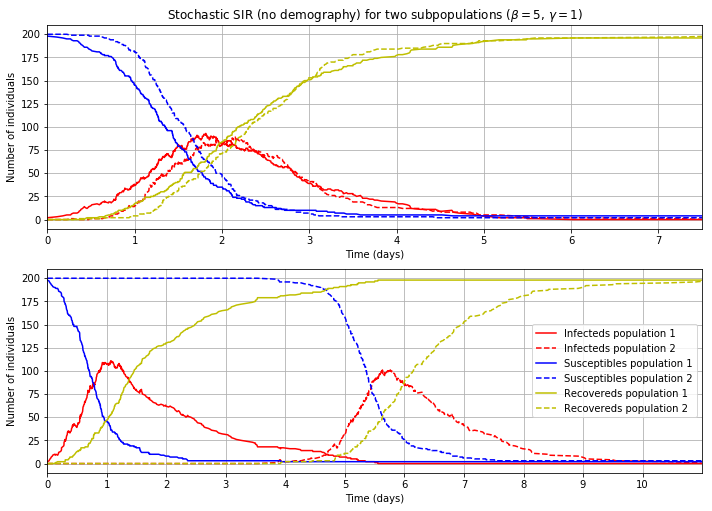

In [11]:
# calculate above function for certain parameters
beta = 5
gamma = 1
rho = 0.05

# seed 
np.random.seed(1337)

# use function
X1_list, Y1_list, Z1_list, X2_list, Y2_list, Z2_list,\
t_list = two_pop_SIR(beta, gamma, rho, 200, 650, 10000)

# plot number of infecteds
fig = plt.figure()
plt.subplot(2, 1, 1)
plt.plot(t_list, Y1_list, color='r', label='Infecteds population 1')
plt.plot(t_list, Y2_list, color='r', linestyle='--', label='Infecteds population 2')
plt.plot(t_list, X1_list, color='b', label='Susceptibles population 1')
plt.plot(t_list, X2_list, color='b', linestyle='--', label='Susceptibles population 2')
plt.plot(t_list, Z1_list, color='y', label='Recovereds population 1')
plt.plot(t_list, Z2_list, color='y', linestyle='--', label='Recovereds population 2')
plt.title('Stochastic SIR (no demography) for two subpopulations ($\\beta = ${}, $\\gamma = ${})'.format(beta, gamma))
plt.ylabel('Number of individuals')
plt.xlabel('Time (days)')
plt.xlim(0, 7.5)
plt.grid()


# calculate above function for certain parameters
beta = 5
gamma = 1
rho = 0.001

# seed 
np.random.seed(12231)

# use function
X1_list, Y1_list, Z1_list, X2_list, Y2_list, Z2_list,\
t_list = two_pop_SIR(beta, gamma, rho, 200, 10500, 10000)

# plot number of infecteds
plt.subplot(2, 1, 2)
plt.plot(t_list, Y1_list, color='r', label='Infecteds population 1')
plt.plot(t_list, Y2_list, color='r', linestyle='--', label='Infecteds population 2')
plt.plot(t_list, X1_list, color='b', label='Susceptibles population 1')
plt.plot(t_list, X2_list, color='b', linestyle='--', label='Susceptibles population 2')
plt.plot(t_list, Z1_list, color='y', label='Recovereds population 1')
plt.plot(t_list, Z2_list, color='y', linestyle='--', label='Recovereds population 2')
plt.legend()
plt.ylabel('Number of individuals')
plt.xlabel('Time (days)')
plt.xlim(0, 11)
plt.xticks(range(11))
plt.grid()
fig.tight_layout()

# shift subplots down:
fig.subplots_adjust(top=0.85)
plt.show()

Let's see what happans if we change the coupling between the populations into a lower value.

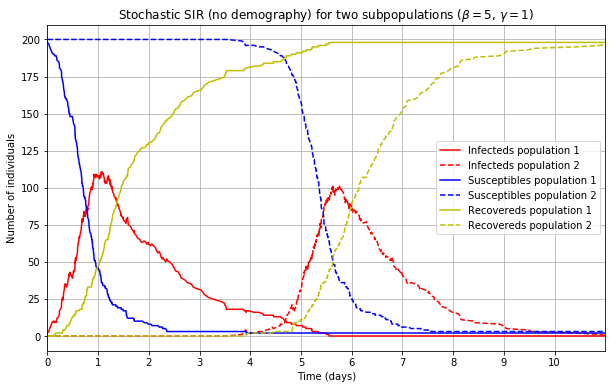

In [33]:
# calculate above function for certain parameters
beta = 5
gamma = 1
rho = 0.001

# seed 
np.random.seed(12231)

# use function
X1_list, Y1_list, Z1_list, X2_list, Y2_list, Z2_list,\
t_list = two_pop_SIR(beta, gamma, rho, 200, 10500, 10000)

# plot number of infecteds
plt.plot(t_list, Y1_list, color='r', label='Infecteds population 1')
plt.plot(t_list, Y2_list, color='r', linestyle='--', label='Infecteds population 2')
plt.plot(t_list, X1_list, color='b', label='Susceptibles population 1')
plt.plot(t_list, X2_list, color='b', linestyle='--', label='Susceptibles population 2')
plt.plot(t_list, Z1_list, color='y', label='Recovereds population 1')
plt.plot(t_list, Z2_list, color='y', linestyle='--', label='Recovereds population 2')
plt.legend()
plt.title('Stochastic SIR (no demography) for two subpopulations ($\\beta = ${}, $\\gamma = ${})'.format(beta, gamma))
plt.ylabel('Number of individuals')
plt.xlabel('Time (days)')
plt.xlim(0, 11)
plt.xticks(range(11))
plt.grid()
plt.show()

#### N Subpopulations

It can be observed that the algorithm above would be hard to implement for more than two populations (the code would soon become very unclear). We change the code in such a way that we have a function in which we can put N subpopulations with coupling terms. 

In [57]:
# function which returns X, Y and Z after one cycle of Gillespie algorithm
# init should be a matrix with initial conditions in the form:
# ([X1, X2, X3], [Y1, Y2, Y3], [Z1, Z2, Z3], ...)
# rho should be a matrix with the coupling terms
# ([rho_11, rho_12, rho_13], [rho_21, rho_22, rho_23],...)
def gill_N_pop(init, beta, gamma, rho, N):
    
    # store rates
    rates = []
    
    # calculate rates for each population
    for i in range(len(init.T)):
        transmission = beta * np.dot(rho[i], init[1]) / N * init[0][i]
        recovery = gamma * init[1][i]
        rates.append(transmission)
        rates.append(recovery)
        
    # total and cumulative rates
    Rtot = sum(rates)
    rates_c = list(accumulate(rates))
        
    # time until next event occurs
    dt = (-1 / Rtot) * np.log(np.random.random())
        
    # calculate P, P = randomnumber * Rtot
    P = np.random.random() * Rtot
    
    # determine which event happens and update values
    for i in range(len(rates_c)):
        if i == 0:
            if P <= rates_c[i]:
                init[0][0] -= 1
                init[1][0] += 1
        
        elif P <= rates_c[i] and P > rates_c[i - 1]:
            
            # transmission
            if i % 2 == 0:
                init[0][int(i / 2)] -= 1
                init[1][int(i / 2)] += 1
            
            # recovery
            else:
                init[1][int((i - 1) / 2)] -= 1
                init[2][int((i - 1) / 2)] += 1
    return init, dt
    
# function which iterates over Gillespie cycles
def iterate_gill_N_pop(init, beta, gamma, rho, N, endtime):
    
    # add init values to list
    xyz_values = []
    x_values = []
    hipspips = np.array(init)
    xyz_values.append(hipspips)
    x_values.append(hipspips[1])
    
    # keep track of time
    t_list = [0]
    i = 0
    time = 0
    
    # keep iterating until endtime is reached
    while(time < endtime):
        newarray, dt = gill_N_pop(init, beta, gamma, rho, N)
        
        # make list with arrays in it
        xyz_values.append(newarray)
        x_values.append(newarray[1])
        time = t_list[i] + dt
        t_list.append(time)
        
        # update counter 
        i += 1
        
        # copy array
        init = np.array(newarray)
        
        # stop if there are no infecteds 
        if all([j == 0 for j in init[1][:]]):
            break    
        
    # return all data
    return xyz_values, t_list, x_values

Lets use the functions above to visualize a time evolution of the stochastic SIR model with 3 populations. All populations have a size of 500 and we start with 100 infecteds in the first population $\rho_{ij}$ for $i \neq j$ is 0.001. 

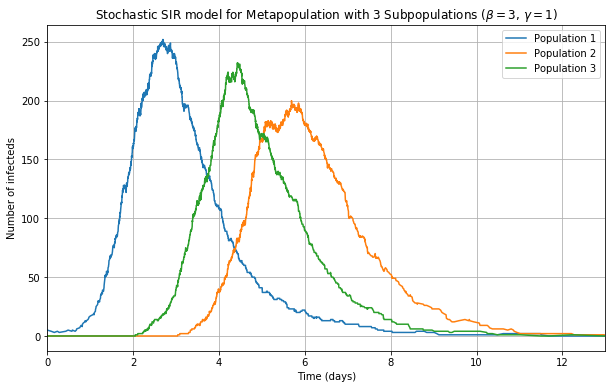

In [175]:
# give array with initial values in form ([x1, x2, x3], [y1, y2, y3],...)
N = 600
init_inf = 5
init = np.array([[N - init_inf, N, N], [init_inf, 0, 0], [0, 0, 0]])

# give coupling values for each population
rho = np.array([[1, 0.001, 0.005], [0.001, 1, 0.01], [0.005, 0.01, 1]])

# seed 
np.random.seed(123456)

# calculate solution with above function
beta = 3
gamma = 1
value_array, time, x = iterate_gill_N_pop(init, beta, gamma, rho, 500, 100)
value_array = np.array(value_array)

# plot solutions
plt.plot(time, value_array[:, 1, 0], label='Population 1')
plt.plot(time, value_array[:, 1, 1], label='Population 2')
plt.plot(time, value_array[:, 1, 2], label='Population 3')
plt.legend()
plt.grid()
plt.title('Stochastic SIR model for Metapopulation with 3 Subpopulations ($\\beta = ${}, $\\gamma = ${})'.format(beta, gamma))
plt.xlabel('Time (days)')
plt.ylabel('Number of infecteds')
plt.xlim(0, 13)
plt.show()

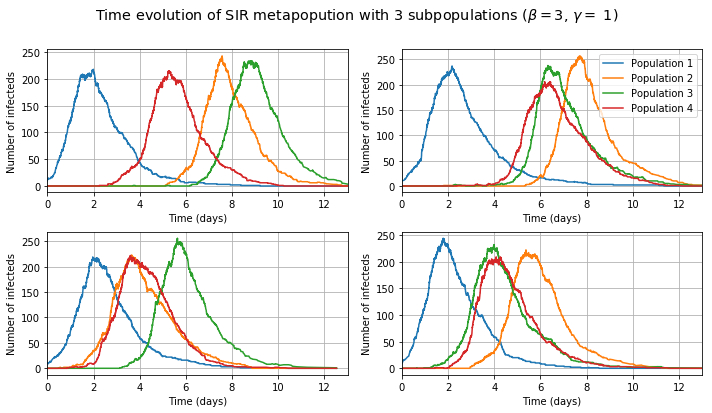

In [171]:
# give array with initial values in form ([x1, x2, x3], [y1, y2, y3],...)
N = 600
init_inf = 10
init = np.array([[N - init_inf, N, N, N], [init_inf, 0, 0, 0], [0, 0, 0, 0]])

# give coupling values for each population
rho = np.array([[1, 0.001, 0.001, 0.001], [0.001, 1, 0.001, 0.001], [0.001, 0.001, 1, 0.001], [0.001, 0.001, 0.001, 1]])

# seed 
np.random.seed(12456)

# calculate solution with above function
beta = 3
gamma = 1
value_array, time, x = iterate_gill_N_pop(init, 3, 1, rho, 500, 100)
value_array = np.array(value_array)

# plot solutions in subplots
fig = plt.figure()
st = fig.suptitle("Time evolution of SIR metapopution with 3 subpopulations ($\\beta = ${}, $\\gamma =$ {})".format(beta, gamma), fontsize="x-large")
plt.figure(1)
plt.subplot(221)
plt.plot(time, value_array[:, 1, 0], label='Population 1')
plt.plot(time, value_array[:, 1, 1], label='Population 2')
plt.plot(time, value_array[:, 1, 2], label='Population 3')
plt.plot(time, value_array[:, 1, 3], label='Population 4')
plt.grid()
plt.xlabel('Time (days)')
plt.ylabel('Number of infecteds')
plt.xlim(0, 13)

# seed 156
np.random.seed(19999096)

# calculate solution with above function
value_array, time, x = iterate_gill_N_pop(init, 3, 1, rho, 500, 100)
value_array = np.array(value_array)

# subplot 2
plt.subplot(222)
plt.plot(time, value_array[:, 1, 0], label='Population 1')
plt.plot(time, value_array[:, 1, 1], label='Population 2')
plt.plot(time, value_array[:, 1, 2], label='Population 3')
plt.plot(time, value_array[:, 1, 3], label='Population 4')
plt.legend()
plt.grid()
plt.xlabel('Time (days)')
plt.ylabel('Number of infecteds')
plt.xlim(0, 13)

# seed 
np.random.seed(1589763)

# calculate solution with above function
value_array, time, x = iterate_gill_N_pop(init, 3, 1, rho, 500, 100)
value_array = np.array(value_array)

# subplot 3
plt.subplot(223)
plt.plot(time, value_array[:, 1, 0], label='Population 1')
plt.plot(time, value_array[:, 1, 1], label='Population 2')
plt.plot(time, value_array[:, 1, 2], label='Population 3')
plt.plot(time, value_array[:, 1, 3], label='Population 4')
plt.grid()
plt.xlabel('Time (days)')
plt.ylabel('Number of infecteds')
plt.xlim(0, 13)

# seed 
np.random.seed(123989873)

# calculate solution with above function
value_array, time, x = iterate_gill_N_pop(init, 3, 1, rho, 500, 100)
value_array = np.array(value_array)

# subplot 4
plt.subplot(224)
plt.plot(time, value_array[:, 1, 0], label='Population 1')
plt.plot(time, value_array[:, 1, 1], label='Population 2')
plt.plot(time, value_array[:, 1, 2], label='Population 3')
plt.plot(time, value_array[:, 1, 3], label='Population 4')
plt.grid()
plt.xlabel('Time (days)')
plt.ylabel('Number of infecteds')
plt.xlim(0, 13)
fig.tight_layout()

# shift subplots down:
st.set_y(0.95)
fig.subplots_adjust(top=0.85)
plt.show()


### Lattice based model

To take spatial information into account we will now implement a lattice based (non-stochastic!) model. In this model we have a nxn grid with n² subpopulations. We assume that only direct neighbours interact with a subpopulation.

In [3]:
# function which returns derivatives of each x,y,z in lattice
# we assume birthrate is the same as the mortality rate
def diff_equations_SIR(init, t, beta, gamma, mu, n, N, rho):
    
    # turn list into matrix form 
    matrix = init.reshape(int(n), int(n), 3)
    
    # list with all derivatives
    deriv = []
    
    # iterate over rows 
    for i in range(n):
        
        # iterate over columns
        for j in range(n):
            
            # sums to calculate derivatives
            # rho * Yi (first sum in numerator)
            sum_num_1 = 0
            
            # rho * Yj (2nd sum in numerator)
            sum_num_2 = 0
            
            # rho * Ni (1st sum in denominator)
            sum_den_1 = 0
            
            # rho * Nj (2nd sum in denominator)
            sum_den_2 = 0
    
            # neighbours to the left
            if j > 0:
                
                # add neighbours to sums
                sum_num_1 += rho * matrix[i][j][1]
                sum_num_2 += rho * matrix[i][j - 1][1]
                sum_den_1 += rho * N
                sum_den_2 += rho * N
            
            # neighbours to right
            if j < n - 1:
                sum_num_1 += rho * matrix[i][j][1]
                sum_num_2 += rho * matrix[i][j + 1][1]
                sum_den_1 += rho * N
                sum_den_2 += rho * N
                
            # neighbours above
            if i > 0:
                sum_num_1 = rho * matrix[i][j][1]
                sum_num_2 += rho * matrix[i - 1][j][1]
                sum_den_1 += rho * N
                sum_den_2 += rho * N
                
            # neighbours below
            if i < n - 1:
                sum_num_1 = rho * matrix[i][j][1]
                sum_num_2 += rho * matrix[i + 1][j][1]
                sum_den_1 += rho * N
                sum_den_2 += rho * N
            
            # calculate derivatives
            dxdt = mu * N - beta * matrix[i][j][0] * \
                    ((matrix[i][j][1] - sum_num_1 + sum_num_2) \
                     / (N - sum_den_1 + sum_den_2)) - mu * matrix[i][j][0]
            dydt = beta * matrix[i][j][0] *((matrix[i][j][1] - sum_num_1 \
                                             + sum_num_2) / (N - sum_den_1 \
                                            + sum_den_2)) - (gamma + mu) * matrix[i][j][1]
            dzdt = gamma * matrix[i][j][1] - mu * matrix[i][j][2]
            
            # add all derivatives to list
            deriv.append(dxdt)
            deriv.append(dydt)
            deriv.append(dzdt)
    return deriv

# function to calculate solution of derivatives
def solution_diff_equations_SIR(init, beta, gamma, mu, n, N, rho, endtime, steps):
    
    # list with all solutions
    t = np.linspace(0, endtime, steps)
    sol = odeint(diff_equations_SIR, init, t, args=(beta, gamma, mu, n, N, rho))
    
    # return all timesteps
    return sol.reshape(len(t), n, n, 3)

The wave speed is 1.368593770038479 subpopulations per day.


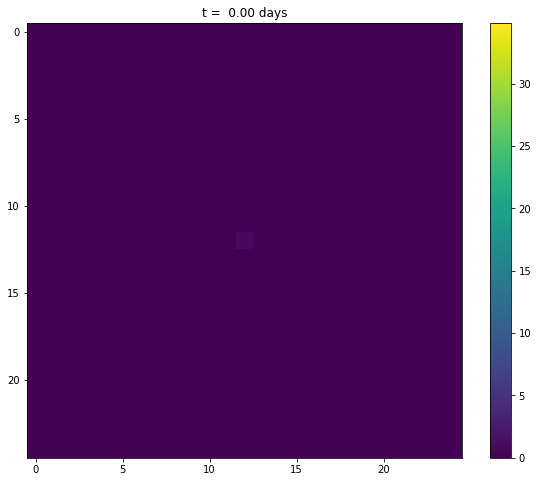

In [26]:
# lets use our function to simulate a meta population
# number of rows and columns (sqrt of # of populations)
n = 25

# number of individuals in each population
N = 100 

# parameters
beta = 3
gamma = 1
mu = 1 / 60
rho = 0.05
endtime = 20
steps = 100

# initial value array
init = np.zeros((n, n, 3))
init[:, :, 0] += N
init[int(n / 2), int(n / 2), 1] = 1
init[int(n / 2), int(n / 2), 0] = N - 1
        
# turn matrix into list 
length = n * n * 3
init_list = init.reshape([length])

# calculate grid for each timestep
xyz_values = solution_diff_equations_SIR(init_list, beta, gamma, mu, n, N, rho, endtime, steps)

# calculate when number of infecteds is max in all subpopulations
times_max = np.argmax(xyz_values[:,:,:,1], axis=0) * (endtime / steps)

# take middle sub population
middle_max_time = times_max[12, 12] 

# take upper right sub population
upper_max_time = times_max[24, 24]

# use pythagoras to determine distance
distance = np.sqrt(12 ** 2 + 12 ** 2)
wavespeed = distance / (upper_max_time - middle_max_time)
print("The wave speed is {} subpopulations per day.".format(wavespeed))

# make figure to plot in
fig = plt.figure()
ax = fig.add_subplot(111)

# plot initial conditions (number of infecteds)
cv0 = xyz_values[0,:,:,1]
im = ax.imshow(cv0) 
cb = fig.colorbar(im)
tx = ax.set_title('Frame 0')

# function to animate each timestep
def animate(i):
    
    # solution at step i
    sol_i = xyz_values[i, :, :, 1]
    
    # define maximum for colorbar
    vmax = np.max(xyz_values[:, :, :, 1])
    
    # display data
    im.set_data(sol_i)
    im.set_clim(0, vmax)
    
    # title for plot
    tx.set_text('t =  {:.2f} days'.format(np.linspace(0, endtime, steps)[i]))

# animate!
animation.FuncAnimation(fig, animate, frames=100)

In [25]:
# calculate when number of infecteds is max in all subpopulations
times_max = np.argmax(xyz_values[:,:,:,1], axis=0) * (endtime / steps)

# take middle sub population
middle_max_time = times_max[12, 12] 
print(middle_max_time)
# take upper right sub population
upper_max_time = times_max[24, 24]
print(upper_max_time)
# use pythagoras to determine distance
distance = np.sqrt(12 ** 2 + 12 ** 2)
wavespeed = distance / (upper_max_time - middle_max_time)
print("The wave speed is {} subpopulations per day.".format(wavespeed))

2.8
15.2
The wave speed is 1.368593770038479 subpopulations per day.


### Lattice Based Model for SIS dynamics

We can use the same algorithm above but now to explore the SIS dynamics. The only things that change are our underlying differential equations. 

In [28]:
# function which returns derivatives of each x,y,z in lattice
# we assume birthrate is the same as the mortality rate
def diff_equations_SIS(init, t, beta, gamma, n, N, rho):
    
    # turn list into matrix form 
    matrix = init.reshape(int(n), int(n), 2)
    
    # list with all derivatives
    deriv = []
    
    # iterate over rows 
    for i in range(n):
        
        # iterate over columns
        for j in range(n):
            
            # sums to calculate derivatives
            # rho * Yi (first sum in numerator)
            sum_num_1 = 0
            
            # rho * Yj (2nd sum in numerator)
            sum_num_2 = 0
            
            # rho * Ni (1st sum in denominator)
            sum_den_1 = 0
            
            # rho * Nj (2nd sum in denominator)
            sum_den_2 = 0
    
            # neighbours to the left
            if j > 0:
                
                # add neighbours to sums
                sum_num_1 += rho * matrix[i][j][1]
                sum_num_2 += rho * matrix[i][j - 1][1]
                sum_den_1 += rho * N
                sum_den_2 += rho * N
            
            # neighbours to right
            if j < n - 1:
                sum_num_1 += rho * matrix[i][j][1]
                sum_num_2 += rho * matrix[i][j + 1][1]
                sum_den_1 += rho * N
                sum_den_2 += rho * N
                
            # neighbours above
            if i > 0:
                sum_num_1 = rho * matrix[i][j][1]
                sum_num_2 += rho * matrix[i - 1][j][1]
                sum_den_1 += rho * N
                sum_den_2 += rho * N
                
            # neighbours below
            if i < n - 1:
                sum_num_1 = rho * matrix[i][j][1]
                sum_num_2 += rho * matrix[i + 1][j][1]
                sum_den_1 += rho * N
                sum_den_2 += rho * N
            
            # calculate derivatives
            dxdt = gamma * matrix[i][j][1] - beta * matrix[i][j][0] * \
                    ((matrix[i][j][1] - sum_num_1 + sum_num_2) \
                     / (N - sum_den_1 + sum_den_2)) 
            dydt = beta * matrix[i][j][0] *((matrix[i][j][1] - sum_num_1 \
                                             + sum_num_2) / (N - sum_den_1 \
                                            + sum_den_2)) - gamma * matrix[i][j][1]
            
            # add all derivatives to list
            deriv.append(dxdt)
            deriv.append(dydt)
    return deriv

# function to calculate solution of derivatives
def solution_diff_equations_SIS(init, beta, gamma, n, N, rho, endtime, steps):
    
    # list with all solutions
    t = np.linspace(0, endtime, steps)
    sol = odeint(diff_equations_SIS, init, t, args=(beta, gamma, n, N, rho))
    
    # return all timesteps
    return sol.reshape(len(t), n, n, 2)

The wave speed is 1.6970562748477138 subpopulations per day.


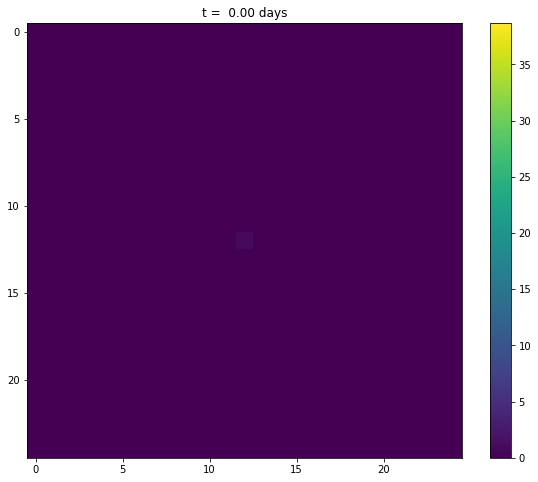

In [29]:
# lets use our function to simulate a meta population
# number of rows and columns (sqrt of # of populations)
n = 25

# number of individuals in each population
N = 100 

# parameters
beta = 1.4
gamma = 1
rho = 0.05
endtime = 200
steps = 100

# initial value array
init = np.zeros((n, n, 2))
init[:, :, 0] += N
init[int(n / 2), int(n / 2), 1] = 1
        
# turn matrix into list 
length = n * n * 2
init_list = init.reshape([length])

# calculate grid for each timestep
xyz_values = solution_diff_equations_SIS(init_list, beta, gamma, n, N, rho, endtime, steps)

# calculate when number of infecteds is max in all subpopulations
times_max = np.argmax(xyz_values[:,:,:,1], axis=0) * (endtime / steps)

# take middle sub population
middle_max_time = times_max[12, 12] 

# take upper right sub population
upper_max_time = times_max[24, 24]

# use pythagoras to determine distance
distance = np.sqrt(12 ** 2 + 12 ** 2)
wavespeed = distance / (upper_max_time - middle_max_time)
print("The wave speed is {} subpopulations per day.".format(wavespeed))

# make figure to plot in
fig = plt.figure()
ax = fig.add_subplot(111)

# plot initial conditions (number of infecteds)
cv0 = xyz_values[0,:,:,1]
im = ax.imshow(cv0) 
cb = fig.colorbar(im)
tx = ax.set_title('Frame 0')

# function to animate each timestep
def animate(i):
    
    # solution at step i
    sol_i = xyz_values[i, :, :, 1]
    
    # define maximum for colorbar
    vmax = np.max(xyz_values[:, :, :, 1])
    
    # display data
    im.set_data(sol_i)
    im.set_clim(0, vmax)
    
    # title for plot
    tx.set_text('t =  {:.2f} days'.format(np.linspace(0, endtime, steps)[i]))

# animate!
animation.FuncAnimation(fig, animate, frames=100)

In [1]:
a = 25
b = int(a / 2)
print(b)

12
